# Exercise 7: Image Classification with Deep Learning

Last week we have seen the basics of PyTorch and its relationship to NumPy, as well as a concept called Object-Oriented Programming. We also designed our first, small model class and had a look at calculating gradients, which is important for training deep learning (DL) models.
Now, we shall finally be doing that! We only need to take a look at a few more concepts, but at the end of this exercise you will have a working image classifier based on a DL model! Let's get started.

## 1. Setup

### 1.1 Install dependencies

In [1]:
import sys
!{sys.executable} -m pip install torch torchvision
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install tqdm                      # this gives us a pretty progress bar

### 1.2 Check if GPU available

Our prospective DL model requires billions of operations to work, all of which can be parallelised by letting them run on the Graphics Processing Unit (GPU).
PyTorch has full support for GPUs and we will make use of it already in this exercise. So let's first test if you have GPU availability.

Run the following code block and proceed if the response is `True`. Else see an instructor.

In [2]:
import torch

print(torch.cuda.is_available())

True


### 1.3 Random seed

Training models relies more or less heavily on randomness. This conflicts with reproducibility: we want to be able to get to the same results if we repeat our experiments.
To solve this contradiction, it is a good idea to initialise the *random number generator* with a *seed*: this way, we will get numbers in a seemingly random, but predictable pattern, which helps reproducing results.

In [3]:
seed = 323444           # the seed value used to initialise the random number generator of PyTorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## 2. Data Loading

Here, we get the dataset and write some code to make it accessible to our prospective DL model.

### 2.1 Download data

Let's download and unzip the [UC Merced Land Use dataset](http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip) for this exercise.

In [ ]:
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip UCMerced_LandUse.zip

### 2.3 Write a PyTorch Dataset class

In previous cases, we were able to load all of our data into system memory to train machine learning models.
For DL, this does not work anymore, because we have to use potentially millions of images. Furthermore, since we are dealing with images, we have no clear definition of labels – for example, a model does not know what to do with the information that an image is called "mediumresidential00.jpg".

Hence, we need to implement a routine that (i.) keeps track of our many images and only loads them if needed, and (ii.) can prepare the dataset for usage in our prospective DL model.
In PyTorch, this is done through a [Dataset](https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html#create-a-dataset-class) class – if you remember last week's exercise you should know what object classes are.
Let us implement a Dataset class for our UCMerced dataset.

Please take a look on the link to understand how this works and complete the code shell below accordingly.

Tips:
*   Check which functions a `torch.utils.data.Dataset` class requires and implement them accordingly.
*   See last week's exercise on how to load images using PIL (the Python Image Library).
*   In the constructor you see a variable named `transforms`. This is for data augmentation, which we will address later. At this point all you need to know is that you can use this on the PIL images and it will return a `torch.Tensor` directly. So it suffices to use `data = self.transforms(img)`.
*   At this point there is no need to move data onto the GPU; we will do that later.

In [4]:
from torch.utils.data import Dataset

from PIL import Image

import os
import glob


class UCMerced(Dataset):

  # mapping between label class names and indices
  LABEL_CLASSES = {
      'agricultural': 		  0,
      'airplane': 			    1,
      'baseballdiamond': 	  2,
      'beach': 				      3,
      'buildings': 			    4,
      'chaparral': 			    5,
      'denseresidential':   6,
      'forest': 				    7,
      'freeway': 				    8,
      'golfcourse': 			  9,
      'harbor': 				    10,
      'intersection': 		  11,
      'mediumresidential':  12,
      'mobilehomepark': 	  13,
      'overpass': 			    14,
      'parkinglot': 			  15,
      'river': 				      16,
      'runway': 				    17,
      'sparseresidential':  18,
      'storagetanks': 		  19,
      'tenniscourt': 			  20
  }

  # image indices to use for different splits
  SPLITS = {
      'train': list(range(0, 60)),    # use first 60 images of each class for training...
      'val':   list(range(61, 70)),   # ...images 61-70 for model validation...
      'test':  list(range(71, 100))   # ...and the rest for testing
  }

  def __init__(self, transforms, split='train'):
    self.transforms = transforms

    # prepare data
    self.data = []                                  # list of tuples of (image path, label class)
    for labelclass in self.LABEL_CLASSES:
      # get images with correct index according to dataset split
      for imgIndex in self.SPLITS[split]:
        imgName = os.path.join('UCMerced_LandUse/Images', labelclass, f'{labelclass}{str(imgIndex).zfill(2)}.tif')     # example format: 'baseFolder/agricultural/agricultural07.tif'
        self.data.append((
            imgName,
            self.LABEL_CLASSES[labelclass]          # get index for label class
        ))


  #TODO: please provide the remaining functions required for the torch.utils.data.Dataset class.
  def __len__(self):
    return len(self.data)

  
  def __getitem__(self, x):
    imgName, label = self.data[x]

    img = Image.open(imgName)
    tensor = self.transforms(img)
    return tensor, label

### 2.4 Define transforms

We have seen some `transform` operations above, e.g. `ToTensor()`. These are not only used to perform data conversion, but also data **augmentation**. This is vital for DL as it artificially increases the dataset complexity. For example, randomly flipping images horizontally every now and then is a logical operation to perform on remote sensing images; doing it during training exposes the DL model to more variations.

In the following, we will define transforms for training and validation separately.

In [5]:
import torchvision.transforms as T

transforms_train = T.Compose([
  T.Resize((224, 224)),
  #TODO: add your own transforms here
  T.RandomHorizontalFlip(),
  T.RandomVerticalFlip(),
  T.ToTensor()
])

transforms_val = T.Compose([
  T.Resize((224, 224)),
  #TODO: add your own transforms here
  T.ToTensor()
])

### 2.5 Test Dataset class

In [6]:
# create a new instance from our dataset class
dataset_train = UCMerced(transforms_train, split='train')

assert len(dataset_train) == 1260, f'ERROR: incorrect value returned in dataset function "__len__": should be {1260}, got {len(dataset_train)}'     # 21 classes x 60 images for training
sample = dataset_train.__getitem__(1259)
assert isinstance(sample, tuple) and len(sample) == 2, f'ERROR: function "__getitem__" does not return the right number of outputs (should be 2)'
data, target = sample[0], sample[1]
assert data.dim() == 3, f'ERROR: first output of dataset function "__getitem__" is either not a torch.Tensor or has incorrect dimensions ({data.dim()} != 3)'
assert isinstance(target, int) and target >= 0 and target <= 20, f'ERROR: second output of dataset function "__getitem__" is not a correct label (should be int in [0, 20])'

### 2.6 Data loader

Alright, we have our dataset class and can draw image-label pairs from it. For DL, we want to do this many, many times. In fact, we want to even perform each model training step with possibly multiple images at a time; that is, we want to train in **batches** (or minibatches). Our data loading must therefore be very efficient.

PyTorch can handle this for you and provides you with a [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class that can compose images and labels in a multi-threaded way. Let's use it!

In [7]:
from torch.utils.data import DataLoader

def load_dataloader(batch_size, transforms, split='train'):
  return DataLoader(
      UCMerced(transforms, split),
      batch_size=batch_size,
      shuffle=(split=='train'),       # we shuffle the image order for the training dataset
      num_workers=2                   # perform data loading with two CPU threads
  )


# let's test it
batch_size = 8
dl_train = load_dataloader(batch_size, transforms_train, split='train')

print(f'Dataset length: {len(dl_train.dataset)}; data loader length: {len(dl_train)}')     # are the two values the same? Why, resp. why not?

data, labels = iter(dl_train).__next__()    # get the next item from the data loader
print('Item from data loader:')
print(f'  --> data size: {data.size()}')
print(f'  --> labels:    {labels}')

Dataset length: 1260; data loader length: 158
Item from data loader:
  --> data size: torch.Size([8, 3, 224, 224])
  --> labels:    tensor([ 4, 11,  9, 18, 13, 11, 18,  1])


## 3. Create model

Now comes the fun part: we are going to design an actual DL model for classifying the UC Merced images! In this case, this will be a CNN.

### 3.1 Building blocks

Before we get started, we shall explore the different building blocks of CNNs and their implementations in PyTorch. Last week you used some of them: Linear (fully-connected) layers, Rectified Linear Unit (ReLU), etc. Now we will take a look at some more advanced ones. You have seen them in the lecture: convolutions, fully-connected layers, nonlinearities (ReLU, Sigmoid, etc.), Batch Normalisation, etc.

In PyTorch, they are all available via [torch.nn](https://pytorch.org/docs/stable/nn.html). Let's take a look.

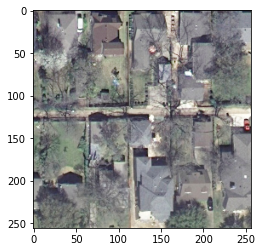

Tensor size: torch.Size([1, 3, 224, 224])


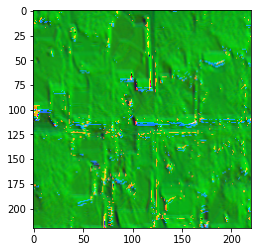

Tensor size after conv: torch.Size([1, 3, 220, 220])


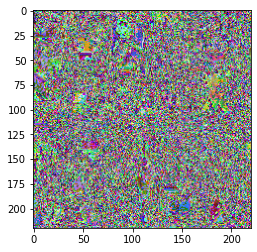

Tensor size after batch norm: torch.Size([1, 3, 220, 220])


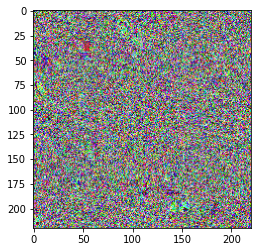

Tensor size after dropout: torch.Size([1, 3, 220, 220])


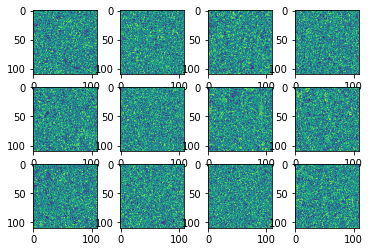

Tensor size after conv2: torch.Size([1, 12, 110, 110])


In [8]:
import torch.nn as nn
import matplotlib.pyplot as plt

toPIL = T.ToPILImage()


# load a random image
img = Image.open('UCMerced_LandUse/Images/mediumresidential/mediumresidential00.tif')
plt.imshow(img); plt.show()

tensor = transforms_train(img)      # we use our data augmentation strategy from above as a pre-processing step for our image

# prepend a dimension to the tensor. This usually is for the number of images (batch size), which is 1 in our case
tensor = tensor.unsqueeze(0)
print(f'Tensor size: {tensor.size()}')

# define and use a Conv2D layer
conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, stride=1, padding=0)
tensor = conv(tensor)
img = toPIL(tensor.detach().squeeze())                      # note the extra .detach() and .squeeze() operations
plt.imshow(img); plt.show()
print(f'Tensor size after conv: {tensor.size()}')

# now a BatchNorm2D layer
bnorm = nn.BatchNorm2d(num_features=3)
tensor = bnorm(tensor)
img = toPIL(tensor.detach().squeeze())
plt.imshow(img); plt.show()
print(f'Tensor size after batch norm: {tensor.size()}')

# dropout with 50% probability
drop = nn.Dropout2d(p=0.5)
tensor = drop(tensor)
img = toPIL(tensor.detach().squeeze())
plt.imshow(img); plt.show()
print(f'Tensor size after dropout: {tensor.size()}')

# another Conv2D layer
conv2 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=2, padding=1)
tensor = conv2(tensor)
plt.subplots(3, 4)
for t in range(tensor.size(1)):
  img = toPIL(tensor[0,t,...].detach().squeeze())
  plt.subplot(3,4,t+1)
  plt.imshow(img); plt.draw();
plt.show()
print(f'Tensor size after conv2: {tensor.size()}')

### 3.2 (+5.2) Define your CNN

Now we will use those building blocks in a CNN. To this end, PyTorch implements models again in a class, this time `torch.nn.Module`. In there, you define:
1.   Which layers your model has;
2.   in which order they are to be executed (the forward pass).

Of course, we do not only want to use our CNN for prediction, but also need to train it. Luckily, however, PyTorch does not require you to implement the backward pass for your layers; it does it automatically for you. This is achieved via [autograd](https://pytorch.org/docs/stable/autograd.html) if you want to read more.

Let's define our model. For this exercise we shall be using an architecture as follows:
1.   2D convolution, 8 kernels of size 7x7, stride 4, zero-padding 0
2.   ReLU
3.   2D max pool, kernel size 3x3, stride 2
4.   2D convolution, 16 kernels of size 5x5, zero-padding 0
5.   ReLU
6.   2D max pool, kernel size 3x3, stride 2
7.   2D convolution, 32 kernels of size 5x5, zero-padding 1
8.   ReLU
9.   Adaptive average pooling, with output size 1x1
10.  Fully-connected (linear) layer, with ? outputs



In [9]:
import torch.nn as nn


class MyModel(nn.Module):

  def __init__(self, num_classes=10):
    '''
        The CNN's constructor, in which we define our actual
        layers.
    '''
    super(MyModel, self).__init__()

    #TODO: define your CNN's building blocks (layers) here.
    self.conv1 = nn.Conv2d(3, 8, kernel_size=7, stride=4, padding=0)
    self.bn1 = nn.BatchNorm2d(8)
    self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
    self.conv2 = nn.Conv2d(8, 16, kernel_size=5, padding=0)
    self.bn2 = nn.BatchNorm2d(16)
    self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
    self.conv3 = nn.Conv2d(16, 32, kernel_size=5, padding=1)
    self.bn3 = nn.BatchNorm2d(32)
    self.fc1 = nn.Linear(32, num_classes)

    self.relu = nn.ReLU()
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))


  def forward(self, x):
    '''
        The forward pass. Here, we receive an input tensor x
        and specify the order in which each layer shall be
        applied to it.
    '''
    x = self.conv1(x)

    #TODO: complete the forward pass definition here.
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    return x

### 3.3 Model unit test

Let's check whether our model does the right thing. If we feed it an image of the right size it should return a tensor with n elements, where n equals the number of classes we have (21 in our case of the UC Merced land use dataset).

In [10]:
num_classes = 21

# create model instance
model = MyModel(num_classes)
print('Model summary:')
print(model)
print('')

# load image and prepare for input to model
img = Image.open('UCMerced_LandUse/Images/mediumresidential/mediumresidential00.tif')
img = T.Resize(size=(224,224))(img)                  # our model requires images to be of size 224x224
tensor = transforms_train(img).unsqueeze(0)
print(f'Input tensor size: {tensor.size()}')

# feed tensor into model. For this, we can just call the model directly on it
with torch.no_grad():
  prediction = model(tensor)

# check whether output size is correct
pred_size = prediction.size(1)
print(f'Prediction tensor size: {prediction.size()}')
assert pred_size == num_classes, \
  f'ERROR: model predicted {pred_size} outputs, but should be {num_classes}'
print('Prediction tensor (model output) values:')
print(prediction)

Model summary:
MyModel(
  (conv1): Conv2d(3, 8, kernel_size=(7, 7), stride=(4, 4))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32, out_features=21, bias=True)
  (relu): ReLU()
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
)

Input tensor size: torch.Size([1, 3, 224, 224])
Prediction tensor size: torch.Size([1, 21])
Prediction tensor (model output) values:
tensor([[-0.3989,  0.1873,  0.6447,  0.1747,  0.2014, -0.1130,  0.2954, -0.149

/opt/miniconda3/envs/env540/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## 4. Implement training routine

Great, we now have our CNN defined. However, if we try and use it as-is on our dataset it is going to perform very poorly. We need to train it on our images, which requires the following steps:


1.   Make prediction with CNN (forward pass)
2.   Calculate loss of prediction w.r.t. ground truth label
3.   Perform backpropagation (backward pass)
4.   Update CNN's parameters

We just did step 1 above, so let's implement the others, too.


### 4.1 Loss function

In the previous exercise you have seen the utility, principle and implementation of a loss function. Now we are going to actually use it, not only to check how well our model is performing, but to optimise (train) it in the first place.
We are designing a model for image classification into pre-defined categories. With that knowledge, please create an instance of the appropriate loss function (see the [documentation](https://pytorch.org/docs/stable/nn.html#loss-functions)).

In [11]:
#TODO
criterion = nn.CrossEntropyLoss()

### 4.2 Optimiser

We can now calculate the loss value for each data point; thanks to autograd we can also calculate the gradients for each model parameter (i.e., perform the backward pass) easily, as you have seen in the previous exercise.

One thing that is not defined yet is a means of updating the CNN's parameters w.r.t. the gradients. This is done with the optimiser. There are multiple options here, but the most known one is called Stochastic Gradient Descent (SGD).
SGD takes the original model parameter values and the calculated gradients, then attenuates (multiplies) it with a given learning rate, optionally applies weight decay and momentum, and updates the model parameters with that. We could implement this manually, but PyTorch has us again covered and provides the most common optimisers [out-of-the-box](https://pytorch.org/docs/stable/optim.html).

Optimisers in PyTorch are classes, such as `torch.optim.SGD`, that receive the models' parameters (to be learned) and *hyper*parameters (that you set manually).

Let us now create a function that returns an instance for SGD. Tip: you can collect all learnable parameters by calling `model.parameters()`.

In [12]:
from torch.optim import SGD

def setup_optimiser(model, learning_rate, weight_decay):
  return SGD(
    model.parameters(),
    learning_rate,
    weight_decay
  )

### 4.3 Definition of training epoch

Now we have all ingredients to train our model!
In DL, a common means to train a model is to perform several passes over the entire training set. This is called an "epoch" (see introductory slides). Let us write a function that performs **one** training epoch. We shall be calling this function n times later on, where we will be performing n training epochs. We supply the following inputs to this function:

*   `data_loader`: an instance of our data loader we defined above
*   `model`: our model instance
*   `criterion`: the loss function used to compare the model's predictions with the ground truth, given the images as input
*   `optimiser`: our optimiser instance
*   `device`: the computation device we want the model to work in. Remember that all data must lie on the same device, including the model's parameters, input tensors, and target tensors.





In [13]:
from tqdm.notebook import trange      # pretty progress bar


def train_epoch(data_loader, model, optimiser, device):

  # set model to training mode. This is important because some layers behave differently during training and testing
  model.train(True)
  model.to(device)

  # stats
  loss_total = 0.0
  oa_total = 0.0

  # iterate over dataset
  pBar = trange(len(data_loader))
  for idx, (data, target) in enumerate(data_loader):

    #TODO: implement the training step here. Check the introductory slides if you need help.

    # put data and target onto correct device
    data, target = data.to(device), target.to(device)

    # reset gradients
    optimiser.zero_grad()

    # forward pass
    pred = model(data)

    # loss
    loss = criterion(pred, target)

    # backward pass
    loss.backward()

    # parameter update
    optimiser.step()

    # stats update
    loss_total += loss.item()
    oa_total += torch.mean((pred.argmax(1) == target).float()).item()

    # format progress bar
    pBar.set_description('Loss: {:.2f}, OA: {:.2f}'.format(
      loss_total/(idx+1),
      100 * oa_total/(idx+1)
    ))
    pBar.update(1)
  
  pBar.close()

  # normalise stats
  loss_total /= len(data_loader)
  oa_total /= len(data_loader)

  return model, loss_total, oa_total

### 4.4 Validation epoch

It is important to check the model's performance on the held-out validation set during training, ideally after every epoch. This will allow you to fine-tune your hyperparameters. Hence, we need to define a second function that does exactly that. This function will be very similar to `train_epoch` we just defined above, but it will only perform validation, no model training.

Tips:
*    You don't need to compute gradients when predicting. Use `with torch.no_grad():` for this.
*    You will want to track two statistics: the average loss and overall accuracy across all the batches.
*    To do so, you can define a variable at the start of the function, add values to it for each batch, and then normalise it by dividing it with the number of batches.
*    For the accuracy you will need to extract the labels from the predicted confidences. This is the index of the prediction with highest confidence value for each image. Function `torch.argmax(...)` can come in very handy here.
*    If a `torch.Tensor` has only one value, you can extract it with `.item()` directly.

In [14]:
def validate_epoch(data_loader, model, device):       # note: no optimiser needed

  # set model to evaluation mode
  model.train(False)
  model.to(device)

  # stats
  loss_total = 0.0
  oa_total = 0.0

  # iterate over dataset
  pBar = trange(len(data_loader))
  for idx, (data, target) in enumerate(data_loader):
    with torch.no_grad():

      #TODO: likewise, implement the validation routine. This is very similar, but not identical, to the training steps.

      # put data and target onto correct device
      data, target = data.to(device), target.to(device)

      # forward pass
      pred = model(data)

      # loss
      loss = criterion(pred, target)

      # stats update
      loss_total += loss.item()
      oa_total += torch.mean((pred.argmax(1) == target).float()).item()

      # format progress bar
      pBar.set_description('Loss: {:.2f}, OA: {:.2f}'.format(
        loss_total/(idx+1),
        100 * oa_total/(idx+1)
      ))
      pBar.update(1)

  pBar.close()

  # normalise stats
  loss_total /= len(data_loader)
  oa_total /= len(data_loader)

  return loss_total, oa_total

Now, go back to `train_epoch` and implement the same accuracy evaluation procedures in there.

## 5. Putting it all together

Let us now combine all the puzzle pieces! Remember that we want to run several epochs, consisting of training and validation each time. This requires another `for`-loop.

First, however, we need some auxiliary functions to load and save our model and its learned parameters after each epoch.

In [15]:
import glob

os.makedirs('cnn_states/MyModel', exist_ok=True)

def load_model(num_classes, epoch='latest'):
  model = MyModel(num_classes)
  modelStates = glob.glob('cnn_states/MyModel/*.pth')
  if len(modelStates) and (epoch == 'latest' or epoch > 0):
    modelStates = [int(m.replace('cnn_states/MyModel/','').replace('.pth', '')) for m in modelStates]
    if epoch == 'latest':
      epoch = max(modelStates)
    stateDict = torch.load(open(f'cnn_states/MyModel/{epoch}.pth', 'rb'), map_location='cpu')
    model.load_state_dict(stateDict)
  else:
    # fresh model
    epoch = 0
  return model, epoch


def save_model(model, epoch):
  torch.save(model.state_dict(), open(f'cnn_states/MyModel/{epoch}.pth', 'wb'))

### 5.1 (+5.3) Model training routine

Now, we will implement the main routine, consisting of the following steps:


1.   Define hyperparameters
2.   Initialise data loaders (train + val)
3.   Load model, set up optimiser
4.   For n epochs, perform training, validation, save model



In [16]:
# define hyperparameters
device = 'cuda'
start_epoch = 0        # set to 0 to start from scratch again or to 'latest' to continue training from saved checkpoint
batch_size = 32
learning_rate = 0.1
weight_decay = 0.001
num_epochs = 10



# initialise data loaders
dl_train = load_dataloader(batch_size, transforms_train, 'train')               #TODO
dl_val = load_dataloader(batch_size, transforms_val, 'val')                     #TODO

# load model
model, epoch = load_model(num_classes=21, epoch=start_epoch)                    #TODO
optim = setup_optimiser(model, learning_rate, weight_decay)                     #TODO

# do epochs
while epoch < num_epochs:

  # training
  model, loss_train, oa_train = train_epoch(dl_train, model, optim, device)     #TODO

  # validation
  loss_val, oa_val = validate_epoch(dl_val, model, device)                      #TODO

  # print stats
  print('[Ep. {}/{}] Loss train: {:.2f}, val: {:.2f}; OA train: {:.2f}, val: {:.2f}'.format(
      epoch+1, num_epochs,
      loss_train, loss_val,
      100*oa_train, 100*oa_val
  ))

  # save model
  epoch += 1
  save_model(model, epoch)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[Ep. 1/10] Loss train: 2.70, val: 2.72; OA train: 22.01, val: 15.16


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[Ep. 2/10] Loss train: 2.29, val: 10.51; OA train: 33.96, val: 4.69


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[Ep. 3/10] Loss train: 2.06, val: 2.11; OA train: 39.04, val: 32.45


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[Ep. 4/10] Loss train: 1.86, val: 3.11; OA train: 44.24, val: 11.46


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[Ep. 5/10] Loss train: 1.70, val: 3.91; OA train: 47.71, val: 10.94


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[Ep. 6/10] Loss train: 1.57, val: 2.27; OA train: 49.53, val: 28.70


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[Ep. 7/10] Loss train: 1.50, val: 2.89; OA train: 52.03, val: 26.56


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[Ep. 8/10] Loss train: 1.40, val: 2.80; OA train: 55.47, val: 27.82


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[Ep. 9/10] Loss train: 1.32, val: 3.49; OA train: 56.77, val: 16.77


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[Ep. 10/10] Loss train: 1.25, val: 2.48; OA train: 59.77, val: 23.71


## 6. Model test

Are you happy with your model? Then let's finally see how well it performs on the test set!

### 6.1 Test on all three sets

In [17]:
# initialise final data loader
dl_test = load_dataloader(batch_size, transforms_val, 'test')       #TODO

# load latest model
model, epoch = load_model(num_classes=21, epoch='latest')           #TODO
print(f'Loaded model at epoch {epoch}.')

# predict on all three sets
loss_train, oa_train = validate_epoch(dl_train, model, device)      #TODO
loss_val, oa_val = validate_epoch(dl_val, model, device)            #TODO
loss_test, oa_test = validate_epoch(dl_test, model, device)         #TODO

# print results
print('Split\tLoss\tOA\n-----------------------')
print('train\t{:.2f}\t{:.2f}'.format(loss_train, oa_train))
print('val\t{:.2f}\t{:.2f}'.format(loss_val, oa_val))
print('test\t{:.2f}\t{:.2f}'.format(loss_test, oa_test))

Loaded model at epoch 10.


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Split	Loss	OA
-----------------------
train	2.15	0.35
val	2.48	0.24
test	2.99	0.22


## 7. Scale it up

Our custom model is rather small and quite difficult to train. Let's see what happens if we replace it with a larger, proven architecture, in this case a ResNet-18.

In [18]:
from torchvision.models import resnet


class MyResNet18(nn.Module):
    def __init__(self, num_classes, pretrained=False):
        super(MyResNet18, self).__init__()

        # initialise standard ResNet-18
        resnet18 = resnet.resnet18(pretrained)

        # keep all layers except for the last one (the original 1000-way fully-connected)
        self.featureExtractor = nn.Sequential(*list(resnet18.children())[:-1])

        # create a new fully-connected layer for our number of classes
        self.cls = nn.Linear(512, num_classes)      # ResNet-18 has a 512-dimensional output prior to the ultimate layer
    
    def forward(self, x):
        # apply all but the last layer of the ResNet-18...
        x = self.featureExtractor(x)
        x = torch.flatten(x, 1)

        # ...and now our own fully-connected layer
        x = self.cls(x)

        return x


### 7.2-7.4 Train ResNet-18

The following code block is almost identical to the one we used above for our own model, except that it trains ResNet-18 and also reports the time required for each training and validation epoch.

In [19]:
# define hyperparameters
pretrained = True         # 7.3: set to either True or False and observe learning speed and final performance after n epochs
device = 'cuda'           # 7.4: set to either 'cpu' or 'cuda' and observe training and validation speed differences...
start_epoch = 0           # set to 0 to start from scratch again or to 'latest' to continue training from saved checkpoint
batch_size = 32
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 10


# initialise data loaders
dl_train = load_dataloader(batch_size, transforms_train, 'train')           #TODO
dl_val = load_dataloader(batch_size, transforms_val, 'val')                 #TODO

# load model
os.makedirs('cnn_states/ResNet18', exist_ok=True)

def load_model(num_classes, epoch='latest'):
  model = MyResNet18(num_classes, pretrained=True)
  modelStates = glob.glob('cnn_states/ResNet18/*.pth')
  if len(modelStates) and (epoch == 'latest' or epoch > 0):
    modelStates = [int(m.replace('cnn_states/ResNet18/','').replace('.pth', '')) for m in modelStates]
    if epoch == 'latest':
      epoch = max(modelStates)
    stateDict = torch.load(open(f'cnn_states/ResNet18/{epoch}.pth', 'rb'), map_location='cpu')
    model.load_state_dict(stateDict)
  else:
    # fresh model
    epoch = 0
  return model, epoch


def save_model(model, epoch):
  torch.save(model.state_dict(), open(f'cnn_states/ResNet18/{epoch}.pth', 'wb'))

model, epoch = load_model(num_classes=21, epoch=start_epoch)                #TODO
optim = setup_optimiser(model, learning_rate, weight_decay)                 #TODO

# do epochs
import time
while epoch < num_epochs:

  # training
  tic = time.time()
  model, loss_train, oa_train = train_epoch(dl_train, model, optim, device) #TODO
  toc_train = (time.time() - tic)

  # validation
  tic = time.time()
  loss_val, oa_val = validate_epoch(dl_val, model, device)                  #TODO
  toc_val = (time.time() - tic)

  # print stats
  print('[Ep. {}/{}] Loss train: {:.2f}, val: {:.2f}; OA train: {:.2f}, val: {:.2f}, time train: {:.2f}s, val: {:.2f}s'.format(
      epoch+1, num_epochs,
      loss_train, loss_val,
      100*oa_train, 100*oa_val,
      toc_train, toc_val
  ))

  # save model
  epoch += 1
  save_model(model, epoch)


# perform final run on test set
loss_test, oa_test = validate_epoch(dl_test, model, device)                 #TODO

# print results
print('Split\tLoss\tOA\n-----------------------')
print('train\t{:.2f}\t{:.2f}'.format(loss_train, oa_train))
print('val\t{:.2f}\t{:.2f}'.format(loss_val, oa_val))
print('test\t{:.2f}\t{:.2f}'.format(loss_test, oa_test))

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[Ep. 1/10] Loss train: 3.01, val: 2.81; OA train: 7.37, val: 12.46, time train: 2.25s, val: 0.43s


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[Ep. 2/10] Loss train: 2.66, val: 2.57; OA train: 24.19, val: 27.41, time train: 2.26s, val: 0.44s


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[Ep. 3/10] Loss train: 2.40, val: 2.35; OA train: 38.65, val: 38.40, time train: 2.21s, val: 0.42s


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[Ep. 4/10] Loss train: 2.14, val: 2.17; OA train: 51.51, val: 47.83, time train: 2.27s, val: 0.45s


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[Ep. 5/10] Loss train: 1.96, val: 1.98; OA train: 60.70, val: 53.14, time train: 2.34s, val: 0.42s


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[Ep. 6/10] Loss train: 1.75, val: 1.81; OA train: 69.04, val: 59.97, time train: 2.37s, val: 0.44s


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[Ep. 7/10] Loss train: 1.59, val: 1.66; OA train: 73.20, val: 66.22, time train: 2.33s, val: 0.49s


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[Ep. 8/10] Loss train: 1.44, val: 1.54; OA train: 78.59, val: 69.97, time train: 2.37s, val: 0.49s


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[Ep. 9/10] Loss train: 1.28, val: 1.42; OA train: 83.39, val: 74.14, time train: 2.37s, val: 0.51s


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

[Ep. 10/10] Loss train: 1.18, val: 1.34; OA train: 84.66, val: 77.42, time train: 2.27s, val: 0.43s


  0%|          | 0/20 [00:00<?, ?it/s]

Split	Loss	OA
-----------------------
train	1.18	0.85
val	1.34	0.77
test	1.37	0.72
